In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import bartlett, levene, jarque_bera, normaltest
from statsmodels.tsa.stattools import acf
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged', con=engine)

engine.dispose()

In [3]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [71]:
#removing rows that have 0 humidity as this is physically impossible
#outside of a laboratory environment
weather_df['temp_diff'] = weather_df['temperature'] - weather_df['apparenttemperature']
no_humidity = weather_df.loc[weather_df['humidity'] == 0]

weather_df.drop(no_humidity.index, inplace=True)
len(weather_df)

96431

In [72]:
Y = weather_df['temp_diff']
X = weather_df[[
    'humidity', 
    'windspeed'
]]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              temp_diff   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 1.965e+04
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:26:41   Log-Likelihood:            -1.7023e+05
No. Observations:               96431   AIC:                         3.405e+05
Df Residuals:                   96428   BIC:                         3.405e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4585      0.021   -116.947      0.000      -2.500      -2.417
humidity       3.0537      0.024    127.531      0.000       3.007       3.101
windspeed      0.1194      0.001    176.627      0.000       0.118       0.121
==============================================================================
Omnibus:                     3512.457   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3994.499
Skew:                           0.459   Prob(JB):                         0.00
Kurtosis:                       3.387   Cond. No.                         88.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The estimated coefficients are both statistically significant for this model. For humidity the coefficient is saying that as humidity increases the difference between the temperature and apparent temperature is increasing by 3 degrees. The windspeed coefficient is saying that as windspeed increases the change in the temperature_diff target will increase by 0.1194 degrees.

The relationship between humidity and windspeed with the difference between the temperature and apparent temperature make sense, both of the features will change how the actual temperature outside feels. In this case increasing the humidity will make it feel colder and increasing the windspeed will make it feel colder.

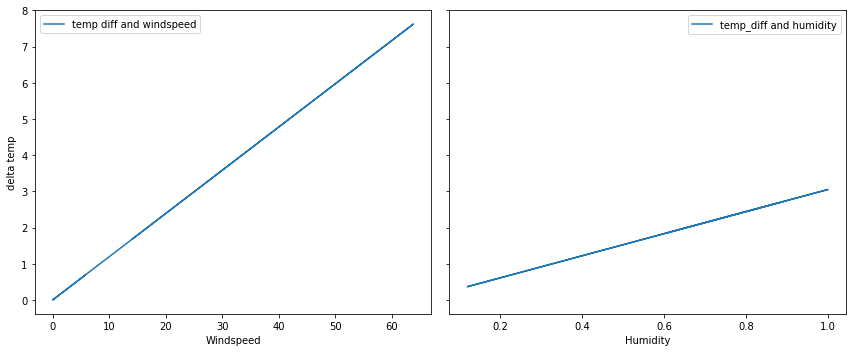

In [73]:
temp_diff_humid = weather_df.humidity * 3.0537
temp_diff_windspeed = weather_df.windspeed * 0.1194


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))

ax1.plot(weather_df['windspeed'], temp_diff_windspeed)
ax1.legend(['temp diff and windspeed'])
ax1.set_ylabel('delta temp')
ax1.set_xlabel('Windspeed')

ax2.plot(weather_df['humidity'], temp_diff_humid)
ax2.legend(['temp_diff and humidity'])
ax2.set_xlabel('Humidity')

f.tight_layout()
f.show()

In [74]:
weather_df['humid_windspeed'] = weather_df['humidity'] * weather_df['windspeed']

In [75]:
Y = weather_df['temp_diff']
X = weather_df[[
    'humidity', 
    'windspeed',
    'humid_windspeed'
]]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              temp_diff   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                 1.682e+04
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:29:49   Log-Likelihood:            -1.6641e+05
No. Observations:               96431   AIC:                         3.328e+05
Df Residuals:                   96427   BIC:                         3.329e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0872      0.033     -2.611      0.009      -0.153      -0.022
humidity           -0.1752      0.043     -4.079      0.000      -0.259      -0.091
windspeed          -0.0918      0.002    -37.331      0.000      -0.097      -0.087
humid_windspeed     0.2990      0.003     89.078      0.000       0.292       0.306
==============================================================================
Omnibus:                     4017.847   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7049.641
Skew:                           0.346   Prob(JB):                         0.00
Kurtosis:                       4.130   Cond. No.                         194.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All of the features are still statistically significant for the model. Interestingly the inclusion of the humid_windspeed variable has caused the signs of the coefficients to change for windspeed and humidity. Now, as humidity or windspeed increase, the temperature difference is decreasing slightly. The new feature humid_windspeed's coefficient means that as they are both increasing then the difference between the temperatures is increasing. Because the original variables showed a divergence from the real temp to the apparent temp as the features increased, the humid_windspeed features increase in temperature separation is even larger.

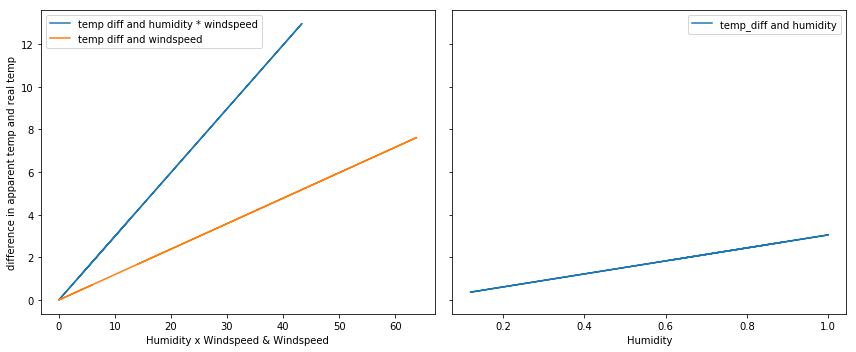

In [77]:
temp_diff_humid_windspeed = weather_df.humid_windspeed * 0.2990
temp_diff_humid = weather_df.humidity * 3.0537
temp_diff_windspeed = weather_df.windspeed * 0.1194


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))

ax1.plot(weather_df['humid_windspeed'], temp_diff_humid_windspeed)
ax1.plot(weather_df['windspeed'], temp_diff_windspeed)
ax1.legend([
    'temp diff and humidity * windspeed', 
    'temp diff and windspeed'])
ax1.set_ylabel('difference in apparent temp and real temp')
ax1.set_xlabel('Humidity x Windspeed & Windspeed')

ax2.plot(weather_df['humidity'], temp_diff_humid)
ax2.legend(['temp_diff and humidity'])
ax2.set_xlabel('Humidity')

f.tight_layout()
f.show()